In [4]:
import sys
sys.path.append('..')
import os
from os.path import join
import numpy as np
import pandas as pd
import connattractor.network as network
import connattractor.analysis as analysis
from sklearn.preprocessing import StandardScaler

import pickle

import seaborn as sns
sns.set_style("whitegrid")

In [9]:
# load embedding
with open('../data_out/default_hopfield_embedding_0.37.pkl', 'rb') as file:
    hopfield_embedding = pickle.load(file)
    
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob(root_dir + 'bochum-???.tsv'):
    path, filename = os.path.split(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(path + '/FD_' + os.path.splitext(filename)[0] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

#all_ts = np.vstack([i for i in all_ts])

/home/renglert/PycharmProjects/connattractor/venv/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/renglert/PycharmProjects/connattractor/venv/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


perc. scrubbed: 0.515


In [30]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'
mtx = pd.read_csv(connfile).iloc[:, 1:]

hopnet = network.Hopfield(mtx, scale=True)
hopnet.beta = 0.045

### Hopnet relaxation

In [105]:
all_trajectories = []

iters = 1000
stepsize = 1
for j in range(len(all_ts[0])):
    ts = all_ts[0][j,:]
    state = ts.copy()
    trajectory = ts.copy()
    for i in range(iters-1):
        state, n_iter, energy = hopnet.update(state, num_iter=stepsize)
        trajectory = np.vstack([trajectory, state])
    all_trajectories.append(trajectory)

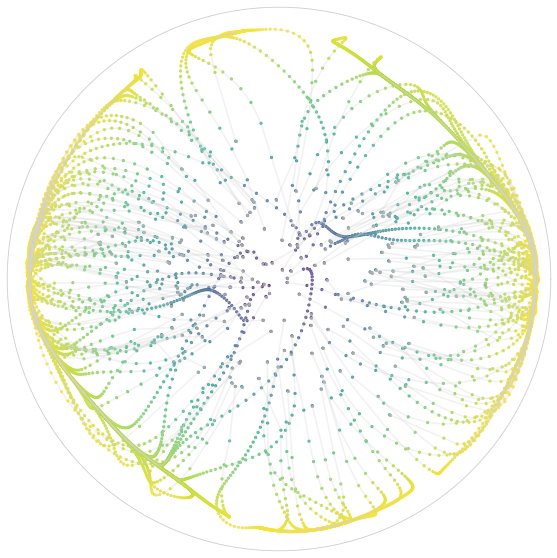

In [112]:
import matplotlib.pyplot as plt
import numpy as np


cmap = plt.get_cmap('viridis')  

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, trajectory in enumerate(all_trajectories):
    trajectory = StandardScaler().fit_transform(np.array(trajectory).T).T
    trajectory_embedded = hopfield_embedding.embedding_model.transform(trajectory)
    r, th = analysis._cart2pol(trajectory_embedded[:, 0], trajectory_embedded[:, 1])

    color = [cmap(x/np.max(r)) for x in r]
    alpha = [x for x in np.linspace(0.8, 0.2, len(trajectory))]

    plt.plot(th, r, 'lightgray', alpha=0.3)
    ax.scatter(th, r, color=color, s=5, alpha=alpha) 
    ax.scatter(th[0], r[0], color='darkgray', s=5, alpha=0.8)

ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)

plt.show()


### hopnet relaxation - colored by state

In [211]:
from joblib import Parallel, delayed

def get_attractors_per_timesample(timeseries, hopnet, threshold=0):
    def workhorse(ts_i):
        activity = timeseries[ts_i]
        fit = hopnet.update(activity, threshold=threshold, beta=hopnet.beta)
        attractor_state = np.array(fit[0])
        return attractor_state

    attractor_states = Parallel(n_jobs=-1)(delayed(workhorse)(i) for i in range(len(timeseries)))
    return attractor_states


def label_att_states(attractor_states, statedict, rtol=1e-05, atol=1e-08):
    ts_statelabels = np.zeros(len(attractor_states), dtype=int)
    for ts_i, attractor_state in enumerate(attractor_states):
        # store attractor state labels
        label = -1
        for dict_i, dictval in enumerate(statedict):
            if np.all(np.isclose(attractor_state, dictval, rtol=rtol,
                                 atol=atol)):  # or np.all(np.isclose(-1*attractor_state, dictval)):
                label = dict_i
                break
        if label < 0:
            statedict.append(attractor_state)
            label = len(statedict) - 1
        ts_statelabels[ts_i] = label
    return ts_statelabels, statedict


In [217]:
statedict = []

attractor_states = get_attractors_per_timesample(all_ts[0], hopnet)
ts_att_labels, statedict = label_att_states(attractor_states, statedict)

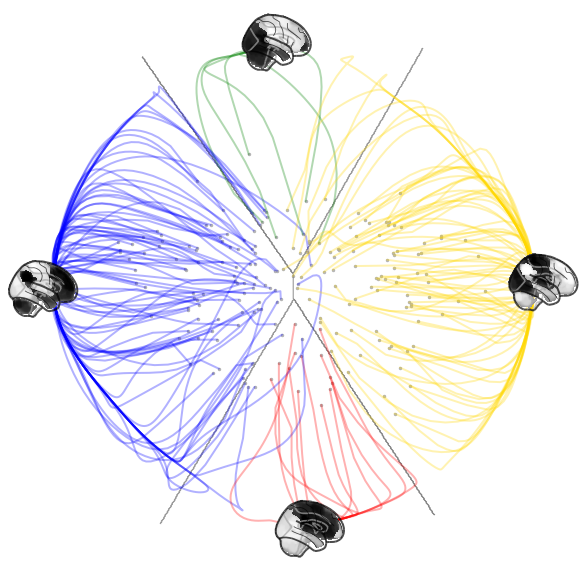

In [242]:
import matplotlib.pyplot as plt
import numpy as np


cmap = plt.get_cmap('viridis')  

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

att_colors = {
    0: 'gold',
    1: 'blue',
    2: 'red',
    3: 'green'
}


hopfield_embedding.plot(
                        all_ts[0],
                        s=10, ax=ax, linewidth=0,
                        alpha=0, regimes_fill_kwargs=dict(alpha=0),
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary')
)


for i, trajectory in enumerate(all_trajectories):
    trajectory = StandardScaler().fit_transform(np.array(trajectory).T).T
    trajectory_embedded = hopfield_embedding.embedding_model.transform(trajectory)
    r, th = analysis._cart2pol(trajectory_embedded[:, 0], trajectory_embedded[:, 1])

    color = [cmap(x/np.max(r)) for x in r]
    alpha = [x for x in np.linspace(0.8, 0.2, len(trajectory))]
    
    line_color = att_colors[ts_att_labels[i]]
    #plt.plot(th, r, 'lightgray', alpha=0.3, linewidth=3)
    ax.plot(th, r, line_color, alpha=0.3, linewidth=2)
    #ax.scatter(th, r, color=color, s=5, alpha=alpha) 
    ax.scatter(th[0], r[0], color='darkgray', s=6, alpha=0.8)

ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)

plt.show()


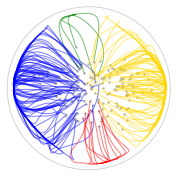

In [244]:
import matplotlib.pyplot as plt
import numpy as np


cmap = plt.get_cmap('viridis')  

fig, ax = plt.subplots(figsize=(3, 3), subplot_kw={'projection': 'polar'})

att_colors = {
    0: 'gold',
    1: 'blue',
    2: 'red',
    3: 'green'
}


for i, trajectory in enumerate(all_trajectories):
    trajectory = StandardScaler().fit_transform(np.array(trajectory).T).T
    trajectory_embedded = hopfield_embedding.embedding_model.transform(trajectory)
    r, th = analysis._cart2pol(trajectory_embedded[:, 0], trajectory_embedded[:, 1])

    color = [cmap(x/np.max(r)) for x in r]
    alpha = [x for x in np.linspace(0.8, 0.2, len(trajectory))]
    
    line_color = att_colors[ts_att_labels[i]]
    #plt.plot(th, r, 'lightgray', alpha=0.3, linewidth=3)
    ax.plot(th, r, line_color, alpha=0.5, linewidth=1)
    #ax.scatter(th, r, color=color, s=5, alpha=alpha) 
    ax.scatter(th[0], r[0], color='darkgray', s=2, alpha=0.8)

ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)

plt.show()


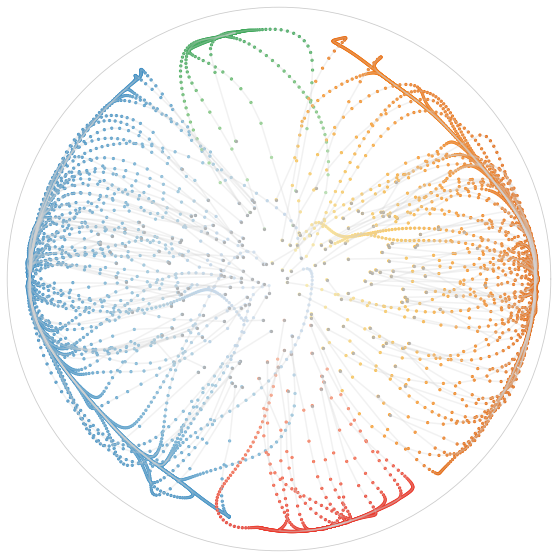

In [273]:
import matplotlib.pyplot as plt
import numpy as np

att_cmaps = {
    0: 'YlOrBr',
    1: 'Blues',
    2: 'Reds',
    3: 'Greens'
}

color_min = 0.1
color_max = 0.15
color_range = color_max - color_min


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, trajectory in enumerate(all_trajectories):
    trajectory = StandardScaler().fit_transform(np.array(trajectory).T).T
    trajectory_embedded = hopfield_embedding.embedding_model.transform(trajectory)
    r, th = analysis._cart2pol(trajectory_embedded[:, 0], trajectory_embedded[:, 1])
    
    cmap = plt.get_cmap(att_cmaps[ts_att_labels[i]])
    
    color = [cmap(color_min + color_range * x) for x in r]
    
    #color = [cmap(x/np.max(r)) for x in r]
    
    #alpha = [x for x in np.linspace(0.8, 0.5, len(trajectory))]
    alpha = 1
    ax.plot(th, r, 'lightgray', alpha=0.3)
    ax.scatter(th, r, color=color, s=5, alpha=alpha) 
    ax.scatter(th[0], r[0], color='darkgray', s=5, alpha=0.8)

ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)

plt.show()


### Trajectory of timeseries in hopfield projection

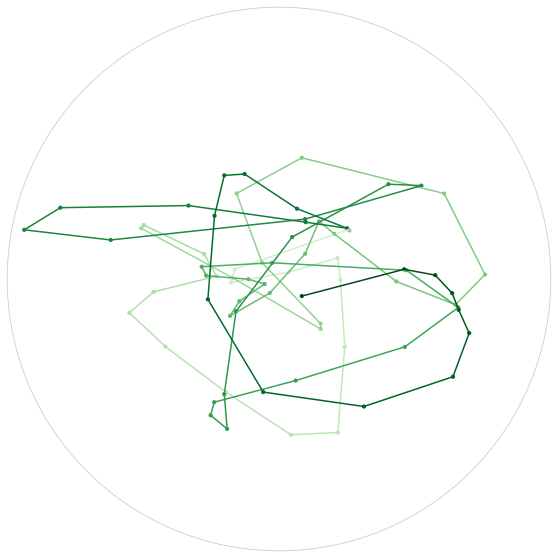

In [189]:
from sklearn.preprocessing import StandardScaler

cmap = plt.get_cmap('Greens')  
color_min = 0.2

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, trajectory in enumerate(all_ts[:1]):
    trajectory = trajectory[:71]
    trajectory = StandardScaler().fit_transform(np.array(trajectory).T).T
    trajectory_embedded = hopfield_embedding.embedding_model.transform(trajectory)
    r, th = analysis._cart2pol(trajectory_embedded[:, 0], trajectory_embedded[:, 1])
    
    #colors = [cmap(x/len(trajectory)) for x in range(len(trajectory))]
    color_val = [x/len(trajectory) for x in range(len(trajectory))]
    colors = [cmap(color_min + (1-color_min) * x) for x in color_val]

    #alphas = np.linspace(0.2, 1, len(trajectory))

    for j in range(len(th) - 1):
        ax.plot(th[j:j+2], r[j:j+2], color=colors[j], alpha=1)
    
    ax.scatter(th, r, color=colors, s=10) 
    
    ax.scatter(th[0], r[0], color='darkgray', s=10, alpha=0.8)
    
ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)

plt.show()


### Trajectory of simulated data in hopfield projection (incl. smoothing)

In [127]:
simresults = analysis.simulate_activations(mtx.values, noise_coef=0.37, 
                                                      num_iter=50000, beta=0.04,
                                                      random_state=42)


100%|██████████| 50000/50000 [00:20<00:00, 2425.62it/s]


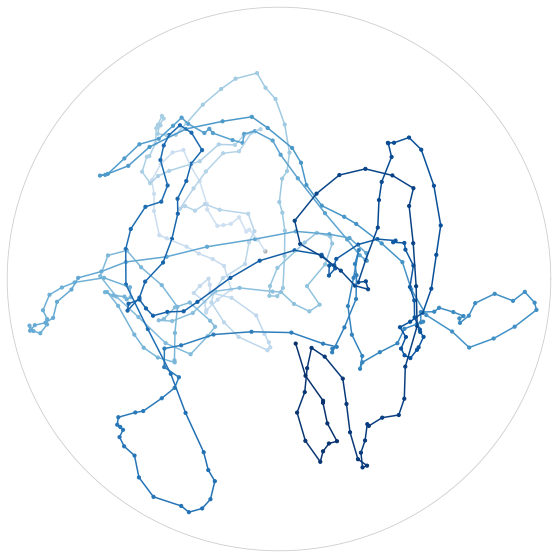

In [194]:
from sklearn.preprocessing import StandardScaler

sample_size = 400
window_size = 5
samples = 400

color_min = 0.2


sim_data = [simresults.states[i:i + sample_size, :] 
            for i in range(0, simresults.states.shape[0], 
                           sample_size)]

cmap = plt.get_cmap('Blues')  

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, trajectory in enumerate(sim_data[:1]):
    trajectory = trajectory[:samples]
    trajectory = StandardScaler().fit_transform(np.array(trajectory).T).T
    trajectory_embedded = hopfield_embedding.embedding_model.transform(trajectory)
    
    x = np.convolve(trajectory_embedded[:, 0], np.ones(window_size)/window_size, mode='same')
    y = np.convolve(trajectory_embedded[:, 1], np.ones(window_size)/window_size, mode='same')
    r, th = analysis._cart2pol(x, y)
    #r, th = analysis._cart2pol(trajectory_embedded[:, 0], trajectory_embedded[:, 1])

    color_val = [x/len(trajectory) for x in range(len(trajectory))]
    colors = [cmap(color_min + (1-color_min) * x) for x in color_val]
    
    #alphas = np.linspace(0.2, 1, len(trajectory))

    for j in range(len(th) - 1):
        ax.plot(th[j:j+2], r[j:j+2], color=colors[j], alpha=1)
    
    ax.scatter(th, r, color=colors, s=10) 
    
    ax.scatter(th[0], r[0], color='darkgray', s=10, alpha=0.8)
    

ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)

plt.show()
